Katrin Erk, June 2023.

# Working with BERT

This notebook demonstrates a few basic techniques for working with *a contextualized language model as data*. Contextualized language models such as BERT and RoBERTa compute context-specific embeddings. They are trained on large amounts of text data. For that reason, we can view them as a compressed record of the utterances of many speakers. So we can use the embeddings from such a model to probe into patterns and regularities in those human speakers' word use (in so far as the model has been able to observe the regularities). Some of these regularities will be syntactic. Others will reflect word senses, and cultural norms and stereotypes. 

In this notebook we focus on BERT because that's the model for which some papers have reported the best performance at mimicking human lexical semantic judgments. We focus on BERT-base, the smaller version of BERT, for simplicity. But thanks to the very easy HuggingFace interface, it should be straightforward to replace the language model.

To probe into the semantic space spanned by BERT, we use classical techniques from distributional modeling: low-dimensionality projection for visualization, and clustering. 

First, here is how we choose the language model to use in HuggingFace:

In [1]:
# We use BERT Base, uncased
checkpoint = 'bert-base-uncased'

# Tokenization

Before a text gets sent through a contextualized language model, it needs to be cut up into pieces: it gets tokenized. Many language models don't tokenize into words, they tokenize into *word pieces*. Many frequent words will be a piece by themselves, but some large and infrequent words get cut up, which has the advantage that the pieces are then again frequent enough to be processed. 

The HuggingFace librar provides a number of tokenizers to match the large language models. We use the tokenizer for BERT base, uncased:

In [2]:
# loading the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The tokenizer object that we just made has several useful methods. First, here is a method to see, in text form, what the tokens are that will be input to BERT. The tokenizer downcases everything (because we've chosen the uncased version of BERT base), splits the text up, where in this case all the word pieces are full words, and adds special tokens to mark boundaries: [CLS] and [SEP]. The example sentence is from the British National Corpus.

In [3]:
bass_sentence = "Drums and bass were as solid as they come and the keyboards filled in any gaps"
tokenizer.tokenize(bass_sentence, add_special_tokens = True)

['[CLS]',
 'drums',
 'and',
 'bass',
 'were',
 'as',
 'solid',
 'as',
 'they',
 'come',
 'and',
 'the',
 'keyboards',
 'filled',
 'in',
 'any',
 'gaps',
 '[SEP]']

Second, here is a method that *does not ever make word pieces* but separates the text into words in the same way as BERT will (because there are always different choices that tokenizers can make, like what to do about the "n't" of "don't"). It also includes character indices for each word, but we won't be using those below. 

In [4]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(bass_sentence)

[('Drums', (0, 5)),
 ('and', (6, 9)),
 ('bass', (10, 14)),
 ('were', (15, 19)),
 ('as', (20, 22)),
 ('solid', (23, 28)),
 ('as', (29, 31)),
 ('they', (32, 36)),
 ('come', (37, 41)),
 ('and', (42, 45)),
 ('the', (46, 49)),
 ('keyboards', (50, 59)),
 ('filled', (60, 66)),
 ('in', (67, 69)),
 ('any', (70, 73)),
 ('gaps', (74, 78))]

In [5]:
# here is this tokenization without the character indices
tokenized_bass_sentence = [w for w, indices in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(bass_sentence)]

Third, and maybe most importantly, there is a method that turns our sentence into the actual input to BERT, a numerical representation:

In [6]:
bert_input_bass = tokenizer(bass_sentence, padding=True, truncation=True, return_tensors="pt")

# bert_input_bass is a complex object, but what we'll need as input to BERT is 
# a list of input IDs that it has computed:
bert_input_bass["input_ids"]

tensor([[  101,  3846,  1998,  3321,  2020,  2004,  5024,  2004,  2027,  2272,
          1998,  1996,  6269,  3561,  1999,  2151, 16680,   102]])

We have two more numerical tokens than input words, as expected, because of the boundary tokens [CLS] and [SEP]. 

In [7]:
print("Number of words:", len(tokenized_bass_sentence))
print("Number of tokens:", bert_input_bass["input_ids"].size(dim=1))

Number of words: 16
Number of tokens: 18


### Actual word pieces

I've promised you word pieces, but in the first sentence we looked at there were none actual pieces. Here is a sentences that does feature word pieces:

In [8]:
pla_sentence = "A platypus went into a bar"
tokenizer.tokenize("A platypus went into a bar", add_special_tokens = True)

['[CLS]',
 'a',
 'pl',
 '##at',
 '##yp',
 '##us',
 'went',
 'into',
 'a',
 'bar',
 '[SEP]']

These word pieces are a problem for when we want to inspect embeddings: BERT will compute separate embeddings for pl, ##at, ##yp, and ##us. If we want to inspect the embedding for "platypus", which one do we use? The standard technique for this is simply to compute the centroid of the embeddings for the pieces of "platypus" (that is, to average over them). 

Like for the "drum and bass" sentence above, we compute a version that is tokenized into words, and a numerical version as input to BERT:

In [9]:
tokenized_pla_sentence = [word for word, location in\
                          tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(pla_sentence)]

bert_input_pla = tokenizer(pla_sentence, padding=True, truncation=True, return_tensors="pt")

# This time, we have a larger discrepancy between number of words and number of tokens:
print("Number of input words:", len(tokenized_pla_sentence))
print("Number of tokens:", bert_input_pla["input_ids"].size(dim=1))

Number of input words: 6
Number of tokens: 11


But if we want to average embeddings, how do we map the word pieces back to their original words? There is another method which, for each word index, gives us the span of tokens that goes with it, `word_to_tokens`, a method to be applied to the output of `tokenizer`. 

In [10]:
for wordindex, word in enumerate(tokenized_pla_sentence):
    print(wordindex, word, bert_input_pla.word_to_tokens(wordindex))

0 A TokenSpan(start=1, end=2)
1 platypus TokenSpan(start=2, end=6)
2 went TokenSpan(start=6, end=7)
3 into TokenSpan(start=7, end=8)
4 a TokenSpan(start=8, end=9)
5 bar TokenSpan(start=9, end=10)


As you can see here, the word "platypus" has tokens 2-6. We will use this information below. 

# Obtaining BERT embeddings for tokens

Now that we have tokenized our text, obtaining embeddings for each word piece is straightforward.

We first load the model, using the same model type as above for the tokenizer so the model gets to see the input it expects.

In [11]:
# loading the model
from transformers import BertModel
model = BertModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


As a reminder, this was the tokenization for our "drum and bass" sentence:

In [12]:
# repeated from above so we don't forget what our data was
bass_sentence = "Drums and bass were as solid as they come and the keyboards filled in any gaps"
bert_input_bass = tokenizer(bass_sentence, padding=True, truncation=True, return_tensors="pt")

Now this one-liner gets us the embeddings *from the last BERT layer* for our sentence:

In [13]:
bert_output_bass = model(bert_input_bass["input_ids"])

The output contains more components. The first component has the actual embeddings. This is a pytorch tensor, which still includes the backpropagation information in `grad_fn`. (We'll get rid of this later to be left with a plain vector.) 

In [14]:
bert_output_bass[0]

tensor([[[ 0.1322, -0.1826, -0.1594,  ..., -0.0822,  0.5888, -0.0451],
         [ 0.7911,  0.8501, -0.3749,  ..., -0.1630,  0.1602, -1.8195],
         [ 0.0235,  0.2925, -0.1801,  ...,  0.2919,  0.0750, -0.3433],
         ...,
         [-0.9090,  0.0147,  1.2571,  ...,  0.3587,  0.0200, -0.1319],
         [-0.0139,  0.3939, -0.0595,  ...,  0.4436,  0.3691,  0.0294],
         [ 0.6088, -0.2614, -0.2469,  ...,  0.0973, -0.3284, -0.4297]]],
       grad_fn=<NativeLayerNormBackward0>)

We got a vector of one component, which consists of 18 embeddings (one per word piece for this sentence), where each embedding has 768 dimensions.:

In [15]:
bert_output_bass[0].size()

torch.Size([1, 18, 768])

Let's match up each word piece with its embedding. At this point, we transform the torch tensor into a plain numpy vector using the methods `detach().numpy()`. This removes the backpropagation information. 

In [16]:
import numpy as np

def matchup_wordpieces_and_embeddings(text, bert_output):
    wordpieces = tokenizer.tokenize(text, add_special_tokens = True)
    embeddings = bert_output[0]
    # we pair up the index and the word piece with the embedding:
    # embeddings[0....] gets us the only row of embeddings in this output,
    # embeddings[0, index...] gets at the embedding for the word piece,
    # and embeddings[0, index, :] says we want all 768 dimensions for this embedding.
    return [ (index, word, embeddings[0, index, :].detach().numpy())
            for index, word in enumerate(wordpieces)]

In [17]:
# We apply our new function to the "drum and bass" sentence:
wv_bass = matchup_wordpieces_and_embeddings(bass_sentence, bert_output_bass)
# word vector for "bass" at index 3, because we have one extra token in front
wv_bass[3]

(3,
 'bass',
 array([ 1.01593161e+00,  8.17085430e-02, -5.45340121e-01,  1.08880838e-02,
        -2.11579293e-01, -3.15094262e-01, -2.14319184e-01,  5.58726490e-01,
        -6.73299789e-01,  9.46505904e-01,  1.02505839e+00, -3.25681686e-01,
        -6.74854279e-01, -1.41160801e-01, -9.40178394e-01,  8.84046972e-01,
         1.90975875e-01, -4.97394592e-01, -2.89675236e-01,  3.59298915e-01,
         8.91669691e-01,  1.48629293e-01,  1.25436053e-01,  1.48651421e-01,
         5.03248036e-01,  1.45630613e-01, -7.93563783e-01,  7.48360753e-01,
        -6.81776345e-01, -6.26385748e-01, -3.02523244e-02,  7.08968759e-01,
         1.54472053e-01,  2.10823625e-01,  6.28727913e-01,  9.12334025e-03,
         6.34278283e-02,  1.06643403e+00,  4.77478087e-01,  1.53698966e-01,
        -5.81581712e-01,  8.10756087e-02,  8.12419504e-02,  4.04577464e-01,
        -2.96735391e-02, -3.58577490e-01,  5.81098199e-01, -7.93567657e-01,
        -1.75972581e-02, -7.10700452e-01, -3.33803862e-01,  7.52502799e-01,

## Combining word pieces.

As we said above, when a word gets split into multiple pieces, like "platypus", we take as the embedding for "platypus" the centroid (average) of the embeddings for "pl", "##at", "##yp", and "##us". 

Here is a function that will do this for us: Given a target word, the text in which it appears, and BERT input and output, it gives us the single embedding for it if it only has a single one, and the averaged embeddings of the word pieces otherwise. 


In [18]:
# This is based on code from Gabriella Chronis' features_in_context

import torch
import numpy

def combined_lastlayer_vector_for(targetword, text, bert_input, bert_output, word_occurrence = 0):
    """
    calculate a word vector
    based on the mean of the WordPiece vectors in the given layer.
    
    targetword is a word appearing in text. 
    
    bert_input is the whole dictionary returned by the tokenizer.
    
    bert_output is the last-layer output obtained 
    on this text. 
    
    word_occurrence: if the target word appears multiple times in the sentence, take the 
    <word_occurrence>-th out of the occurrences. 
    """
    # compute tokenization into words using the same word tokenizer that the language model uses
    tokenized_text = [w for w, n in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]
    
    # where in the tokenized text (split into words but not split into word pieces)
    # do we find the target word?
    target_word_indices = [i for i, x in enumerate(tokenized_text) if x == targetword]
    
    # sanity check
    if len(target_word_indices) < word_occurrence + 1:
        # no occurrences found, or not enough to match the required one
        return None

    # if multiple occurrences of the target word, we use this one
    usethis_targetword_index = target_word_indices[ word_occurrence]
    
    # use word_to_tokens to determine the word piece span of the target word
    word_start, word_end = bert_input.word_to_tokens( usethis_targetword_index )
    
    # collect all the relevant embeddings, from the start token to the end token
    # of the target word
    target_vectors = bert_output[0][0, word_start:word_end, :]
    
    # and average over them (if there is only one vector, this leaves the vector unchanged)
    avg_target_vector = target_vectors.mean(dim = 0)
    
    # change the resulting vector to a plain vector,
    # removing backpropagation information
    return avg_target_vector.detach().numpy()


In [19]:
# Let's apply our new function to the word "bass" in the "drum and bass" sentence
bassvector = combined_lastlayer_vector_for("bass", bass_sentence, 
                                           bert_input_bass, bert_output_bass)

# Because "bass" wasn't split up, the embedding we get for it
# should be the same one that we matched to the word piece "bass" above.
# and it is the same:
np.all(bassvector == wv_bass[3][2])

True

In [20]:
# now let's try a case where we do have multiple word pieces
pla_sentence = "A platypus went into a bar"

# compute embeddings for the platypus sentence
bert_input_pla = tokenizer(pla_sentence, padding=True, truncation=True, return_tensors="pt")
bert_output_pla = model(bert_input_pla["input_ids"])

# match up word pieces and embeddings, as above
wv_pla = matchup_wordpieces_and_embeddings(pla_sentence, bert_output_pla)
print("wv_pla[2] is the vector for", wv_pla[2][1])

# and compute the average embedding over all word pieces for platypus
platypusvector = combined_lastlayer_vector_for("platypus", pla_sentence, 
                                               bert_input_pla, bert_output_pla)

# and now the vector for platypus is not the same as the vector for pl
np.all(platypusvector == wv_pla[2][2])


wv_pla[2] is the vector for pl


False

# Using a layer other than the last

The code above only lets us access the very last layer of embeddings. But BERT base has 12 layers. And in fact the layers differ: We tested how well clusters of BERT embeddings (more on those below) approximate human judgments on word similarity. There is not just one notion of similarity, there are several, with different human judgment datasets to go with them: The words "cat" and "dog" are similar, or taxonomically similar: They will be in a similar place in an ontology because they are both animals, and pets. The words "dog" and "kennel" are related, or topically similar: They are not similar kinds of things, but they'll often appear in the same stories. We found that with BERT embeddings from the last layer, we could best approximate topical similarity, while we could best approximate taxonomic similarity with layers 7 or 8. Here is the paper: https://aclanthology.org/2020.conll-1.17/

So if we want the embeddings that encode something most like dictionary word senses, we need to obtain them from BERT base level 8. 

Here is how to obtain embeddings not just from the last layer but from all of them: 

In [21]:
bert_out_bass_h = model(bert_input_bass["input_ids"], output_hidden_states = True)

`bert_out_bass_h` is a dictionary with different entries. The entry for "hidden_states" has the embeddings from all layers. The entry is a tuple:

In [22]:
type(bert_out_bass_h["hidden_states"])

tuple

And this tuple has 13 entries, one for each layer. 

In [23]:
len(bert_out_bass_h["hidden_states"])

13

Here again is the last layer -- this is the one we used above:

In [24]:
bert_out_bass_h["hidden_states"][-1]

tensor([[[ 0.1322, -0.1826, -0.1594,  ..., -0.0822,  0.5888, -0.0451],
         [ 0.7911,  0.8501, -0.3749,  ..., -0.1630,  0.1602, -1.8195],
         [ 0.0235,  0.2925, -0.1801,  ...,  0.2919,  0.0750, -0.3433],
         ...,
         [-0.9090,  0.0147,  1.2571,  ...,  0.3587,  0.0200, -0.1319],
         [-0.0139,  0.3939, -0.0595,  ...,  0.4436,  0.3691,  0.0294],
         [ 0.6088, -0.2614, -0.2469,  ...,  0.0973, -0.3284, -0.4297]]],
       grad_fn=<NativeLayerNormBackward0>)

And here is layer 8:

In [25]:
bert_out_bass_h["hidden_states"][7]

tensor([[[ 5.2587e-01, -3.9115e-01, -1.8385e-01,  ..., -8.2632e-01,
           7.3814e-01, -2.2118e-02],
         [ 1.8022e+00,  1.5440e+00,  8.0631e-01,  ..., -6.1272e-01,
           1.2419e+00, -2.7058e+00],
         [ 4.3618e-01,  4.6743e-01,  7.1952e-01,  ...,  5.1201e-01,
           1.2187e+00, -1.0408e+00],
         ...,
         [-1.4122e+00,  5.6963e-01,  1.0079e+00,  ...,  3.3302e-01,
          -8.6654e-01, -6.1888e-01],
         [ 5.3986e-01,  7.9858e-01, -4.6613e-02,  ...,  6.3069e-02,
           3.0573e-01,  4.6167e-01],
         [ 1.4215e-02, -1.7786e-02,  6.3283e-04,  ..., -1.4681e-02,
           2.1358e-02, -5.1730e-02]]], grad_fn=<NativeLayerNormBackward0>)

We redefine the two functions we defined above, for matching up word pieces and embeddings and for extracting average embeddings for a word, extending them so that we can specify the layer:

In [26]:
# adapting our function from earlier so that it can take any layer
def matchup_wordpieces_and_embeddings_atlayer(text, bert_output, layer):
    wordpieces = tokenizer.tokenize(text, add_special_tokens = True)
    embeddings = bert_output["hidden_states"][layer]
    return [ (index, word, embeddings[0, index, :].detach().numpy()) 
            for index, word in enumerate(wordpieces)]

We apply this to the "drum and bass" sentence and obtain embeddings from the last layer. This should give us the exact same result as above: 

In [27]:
wv_bass_last = matchup_wordpieces_and_embeddings_atlayer(bass_sentence, bert_out_bass_h, -1)

# we got the last layer, so our output should be the same as before
np.all(wv_bass_last[3][2] == wv_bass[3][2])

True

Now we extract embeddings from layer 8. These embeddings are not the same as the last-layer embeddings we got above:

In [28]:
# obtaining the output at layer 8
wv_bass_8 = matchup_wordpieces_and_embeddings_atlayer(bass_sentence, bert_out_bass_h, 7)

# embedding from last layer and layer 8 shouldn't be the same
np.all(wv_bass_last[3][2] == wv_bass_8[3][2])

False

Now we adapt the function for extracting the average embedding for a word. If no layer is given, it uses the last one by default.

In [29]:
# and adapting the other function
def combined_vector_for(targetword, text, bert_input, bert_output, 
                        layer = -1, word_occurrence = 0):
    """
    calculate a word vector
    based on the mean of the WordPiece vectors in the given layer.
    targetword is a word appearing in text. 
    bert_input is the whole dictionary returned by the tokenizer.
    bert_output is the last-layer output obtained 
    on this text. 
    """
    tokenized_text = [w for w, n in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]
    
    # where in the tokenized text (split into words but not split into word pieces)
    # do we find the target word?
    target_word_indices = [i for i, x in enumerate(tokenized_text) if x == targetword]
    
    # sanity check
    if len(target_word_indices) < word_occurrence + 1:
        # no occurrences found, or not enough to match the required one
        return None

    # if multiple occurrences of the target word, we use this one
    usethis_targetword_index = target_word_indices[ word_occurrence]
    
    # use word_to_tokens to determine the word piece span of the target word
    word_start, word_end = bert_input.word_to_tokens( usethis_targetword_index )
    
    # extract the embeddings from the right layer, and the target vectors from that layer
    embeddings= bert_output["hidden_states"][layer]
    target_vectors = embeddings[0, word_start:word_end, :]
    
    # if we have multiple word pieces for this word, average over them
    avg_target_vector = target_vectors.mean(dim = 0)
    
    return avg_target_vector.detach().numpy()


Here is the layer-8 embedding for "bass" in the "drum and bass" sentence:

In [30]:
bass7 = combined_vector_for("bass", bass_sentence, 
                            bert_input_bass, bert_out_bass_h, layer= 7)
bass7.size

768

# Visualizing embeddings

We can visualize contextualized word embeddings as points in a semantic space. To do that, we again down-project the embeddings to two dimensions. It is particularly nice to visualize tokens of the same lemma, to see which usages lump together as similar. The Context Atlas is a website that does this for word tokens from Wikipedia: https://storage.googleapis.com/bert-wsd-vis/demo/index.html?#word=fire (You can change the word to visualize.)

But let's also look at how to do this "by hand", so we can use our own data rather than just Wikipedia. Here, for demo purposes, we use sentences from the Brown corpus. This is convenient because the Brown corpus comes with the Python nltk package.

We set a target word -- I've set it to "fire", but re-set it to a different word and re-run all the boxes below to visualize another word. We extract all sentences from the Brown corpus that contain the target word:

In [31]:
from nltk.corpus import brown

targetword = "fire"

target_sentences = [s for s in brown.sents() if targetword in s]

# how many sentences did we get?
len(target_sentences)

165

Now let's extract an embedding for our target word from each of the Brown corpus sentences that contain the word. I've added a variable "targetlayer" in which to set the BERT layer to use. I've set it to layer 8 for now, the "most taxonomic" layer.

In [32]:
# for each sentence, we obtain the BERT embedding
# for the target word at a particular layer

targetlayer = 7

# collect embeddings of the target word
target_embeddings = [ ]
# collect sentences that we actually use
# (if something goes wrong, we may skip a sentence.)
used_sentences = [ ]


for sentence in target_sentences:
    
    # The nltk interface gives us the sentence as a list of words.
    # Put them together so we can use the BERT tokenizer.
    sentence_string = " ".join(sentence)
    
    # make input to BERT
    bert_input = tokenizer(sentence_string, 
                           padding=True, truncation=True, return_tensors="pt")
    
    # compute embeddings
    bert_output = model(bert_input["input_ids"], output_hidden_states = True)
    
    # extract the embedding for our target word, from the target layer
    embedding = combined_vector_for(targetword, sentence_string, 
                                    bert_input, bert_output, layer = targetlayer)
    
    if embedding is None:
        # something went wrong, and the target word wasn't found:
        # skip
        continue
        
    # store embedding, and store the sentence, because 
    # now we know that nothing went wrong with it
    target_embeddings.append(embedding)
    used_sentences.append(sentence)

We can now make our first visualization:

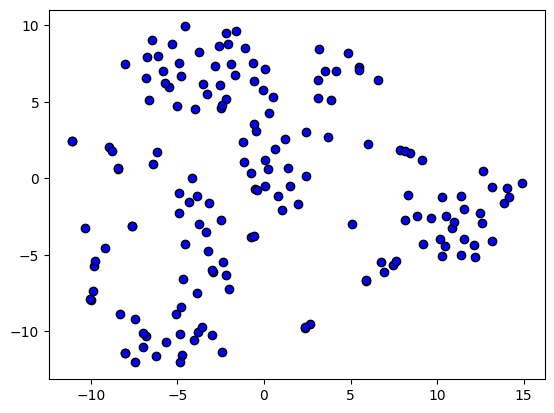

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Project the data down to 2 dimensions
# Here we use t-sne, which makes pretty images,
# but it may over-emphasize any clusters in the data,
# making the data look neater than it is.
tsne_obj = TSNE(n_components=2, random_state = 0)
twodim = tsne_obj.fit_transform(np.array(target_embeddings))

# set up the canvas
fig, ax =  plt.subplots()

# add a scatter plot of the two-D embeddings
scatter = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='b')

# and show the canvas
plt.show()

This is pretty, but not overly informative, because we cannot see which usage is which. So let's make it so that when you hover
over a dot, you see the sentence.

Because some sentences are quite long, let's cut them down to snippets of 5 words to the left and right of the target word for display:

In [34]:
# make sentence snippets for visualization, with the target word in the middle

# this is the list where we'll store our sentence snippets to use as labels
used_sentence_labels = [ ]
for s in used_sentences:
    
    # sanity check
    if targetword not in s:
        # trouble finding the target word:
        # store the original sentence in its entirety
        used_sentence_labels.append(" ".join(s))
        continue
        
    # determine the index of the target word
    targetindex = s.index(targetword)
        
    # window of 5 words left and right of the target, 
    # but don't go below 0 or above the length of the sentence
    snippet_start = max(0, targetindex - 5)
    snippet_end = min(snippet_start + 11, len(s))
    
    # make the snippet, as a string
    snippet = s[snippet_start : snippet_end]
    used_sentence_labels.append(" ".join(snippet))

Now we respecify our visualization, but use mlpd3 to add labels:

In [35]:
# visualization  that works on the list of embeddings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import mpld3

tsne_obj = TSNE(n_components=2, random_state = 0)
twodim = tsne_obj.fit_transform(np.array(target_embeddings))

# set up the canvas
fig, ax =  plt.subplots()

# add a scatter plot of the two-D embeddings
scatter = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')

# this is new: add labels
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=used_sentence_labels)
mpld3.plugins.connect(fig, tooltip)

# and show the canvas
# we let mlpd3 do that so the labels will show
mpld3.display()

# Hover over data points to see the labels!

# Clustering embeddings

In the paper mentioned above, https://aclanthology.org/2020.conll-1.17/, we recommended clustering word token embeddings of a lemma into several clusters that are *multi-prototype embeddings*. That way, we can store the variety of the word's meaning but use less space than if we kept every single token embedding around. It is also useful to inspect the clusters to see how the usages in a cluster relate to each other: Are they like word senses? We found that they do carry word sense information, but often they also store what could be called the stories that people tell with the words. Here is a paper where we discuss some examples: https://utexas.box.com/s/g9evhknb23synx7cg7hurst810v37d8k

Let's cluster the Brown corpus embeddings of our target word that we collected above. We make 5 clusters (change the variable `num_clusters` to adapt this): 

In [36]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import math

# How many clusters to make?
num_clusters = 5

# Make a k-means clustering object. 
# Set the random state so that when we run the box twice, it will give
# exactly the same result.
kmeans_obj = KMeans(n_clusters=num_clusters, n_init = "auto", random_state = 0)

# Cluster the embeddings of the target word
kmeans_obj.fit(target_embeddings)

# label_list is the cluster label (a number) for each data point
label_list = kmeans_obj.labels_

# centroids of the clusters
cluster_centroids = kmeans_obj.cluster_centers_


What clusters did we get? Let's look at a few sentences for each cluster.

In [37]:
# For each cluster number
for cluster in range(num_clusters):
    print("-------- cluster", cluster, "---------")
    
    # retrieve the target word occurrences that were put into this cluster
    sent_this_cluster = [s for ell, s in zip(label_list, used_sentences) if ell == cluster]
    
    # and show 10 of them 
    for s in sent_this_cluster[:10]:
        print(*s, "\n")
        
    print()

-------- cluster 0 ---------
Five , four , three , two , one , fire ! ! 

The most intriguing aspect of the S & W Magnum chambered for the new Jet is that it can also fire standard 

A British officer had come aboard and told him that in case of enemy air attack he was not to open fire until bombs were actually dropped . 

Then he was to co-ordinate his fire with a radar-controlled shore gun firing white tracers . 

Not fire until the bombs came down ! ! 

Vesole rushed from gun to gun , attempting to direct fire . 

The Koreans fell back , but regrouped at the top of the hill and pinned down the cavalrymen with a screen of fire . 

He went down like a wet rag and the attackers hit the dirt in the face of the withering enemy fire . 

In the end we ran into Communist artillery fire . 

These remarkable ships and weapons , ranging the oceans , will be capable of accurate fire on targets virtually anywhere on earth . 


-------- cluster 1 ---------
The jury also commented on the Fulton or

## Adding the clusters to our visualization

We can also add the cluster labels as colors to our visualization. This is very easy: We just hand the scatterplot method the cluster labels
to use as dot colors. 

In [38]:
# visualization with cluster labels as colors

tsne_obj = TSNE(n_components=2, random_state = 0)
twodim = tsne_obj.fit_transform(np.array(target_embeddings))

# set up the canvas
fig, ax =  plt.subplots()

# add a scatter plot of the two-D embeddings
scatter = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=label_list)

# add labels
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=used_sentence_labels)
mpld3.plugins.connect(fig, tooltip)

# and show the canvas
mpld3.display()

